# Efficiency Test Results Visualization

This notebook visualizes the results of the efficiency tests. The goal is to compare the performance of different embedding models (`all-MiniLM-L6-v2` vs. `all-mpnet-base-v2`) across various sample sizes and compute devices (CPU/GPU).

## 1. Import Required Libraries

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style and context for publication quality
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

## 2. Load and Consolidate Test Results
We will walk through the `experiments/efficiency_test` directory, find all `result.json` files, parse the metadata (model, device, sample size) from the file path, and load the data into a single pandas DataFrame.

In [2]:
results_dir = '../experiments/efficiency_test'
all_results = []

def get_scenario_name(scenario: str, model: str) -> str:
    scenario_map = {
        "droptc": "DroPTC",
        "drolove": "DroLoVe",
        "dronelog": "DroneLog",
        "neurallog": "NeuralLog",
        "transsentlog": "TransSentLog"}
    
    model_map = {
        "bert-base-uncased": "BERT-base",
        "all-MiniLM-L6-v2": "MiniLM",
        "all-mpnet-base-v2": "MPNet",
        "neo-bert": "NeoBERT",
        "modern-bert": "ModernBERT"
    }
    if scenario == 'droptc':
        return f"{scenario_map.get(scenario, scenario)}-{model_map.get(model, model)}"
    else:
        return scenario_map.get(scenario, scenario)
    

for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file == 'result.json':
            file_path = os.path.join(root, file)
            
            # Parse metadata from path
            parts = file_path.split(os.sep)
            # print(parts)
            sample_size = int(parts[-2])
            device = parts[-3]
            model = parts[-4]
            scenario = parts[-5]
            scenario = get_scenario_name(scenario, model)
            
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Ensure all keys are present
            data['model'] = data.get('model', model)
            data['device'] = data.get('device', device)
            data['sample_size'] = data.get('sample_size', sample_size)
            data['scenario'] = data.get('scenario', scenario)
            all_results.append(data)

df = pd.DataFrame(all_results)

# Convert relevant columns to numeric, coercing errors
for col in ['sample_size', 'inference_time_s', 'avg_cpu_percent', 'peak_cpu_percent', 'avg_gpu_percent', 'peak_gpu_percent']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Sort the dataframe for better plotting
df = df.sort_values(by=['scenario', 'model', 'device', 'sample_size']).reset_index(drop=True)

In [3]:
df.head()

,model,device,sample_size,batch_size,inference_time_s,avg_cpu_percent,peak_cpu_percent,avg_gpu_percent,peak_gpu_percent,avg_memory_rss_mb,peak_memory_rss_mb,avg_gpu_memory_mb,peak_gpu_memory_mb,scenario
0,bert-base-uncased,cpu,100,32,0.538494,71.716667,100.0,0.0,0,1463.218750,1493.445312,0.0,0.0,DroLoVe
1,bert-base-uncased,cpu,250,32,2.112464,60.919048,67.6,0.0,0,1673.602121,1785.457031,0.0,0.0,DroLoVe
2,bert-base-uncased,cpu,500,32,4.347884,62.561364,67.6,0.0,0,1672.790927,1845.300781,0.0,0.0,DroLoVe
3,bert-base-uncased,cpu,750,32,6.499152,62.326154,67.6,0.0,0,1731.923257,1981.105469,0.0,0.0,DroLoVe
4,bert-base-uncased,cpu,1000,32,8.603228,61.663953,67.7,0.0,0,1916.269077,2242.007812,0.0,0.0,DroLoVe


## 3. Visualize Efficiency Metrics

Now that the data is loaded, we can create plots to compare the models across different metrics. We will use Plotly for interactive visualizations.

### 3.1. Inference Time vs. Sample Size

This plot shows how the total inference time scales with the number of samples. We expect to see a clear difference between the two models, especially on larger sample sizes. The plot is faceted by the device (CPU vs. GPU) to show performance in both environments.

In [63]:
def generate_visz(dataframe, scenario, ncol):
    df = dataframe.copy()
    df['sample_size'] = pd.to_numeric(df['sample_size'])
    df['runtime'] = pd.to_numeric(df['inference_time_s'])

    # Convert sample_size to thousands for labeling
    df['sample_size_k'] = df['sample_size']

    plt.figure(figsize=(5, 3))
    sns.set_style("whitegrid")
    # sns.set_palette("husl")

    # Create line plot
    ax = sns.lineplot(data=df, x='sample_size_k', y='runtime', hue='scenario', 
                    style='scenario', markers=True, dashes=True, markersize=6, linewidth=1.1)

    # Set logarithmic scale if data spans several orders of magnitude
    if df['sample_size_k'].max() / df['sample_size_k'].min() > 100:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1, 100000)
        ax.set_xlabel('Sample Size (log scale)')
        ax.set_ylabel('Runtime (seconds, log scale)')
    else:
        ax.set_xlabel('Sample Size')
        ax.set_ylabel('Runtime (seconds)')

    # plt.title('Log Abstraction Efficiency Comparison', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=ncol)
    plt.tight_layout()
    plt.savefig(f'../visualization/efficiency-test/{scenario}.pdf', bbox_inches='tight', dpi=600)
    plt.show()

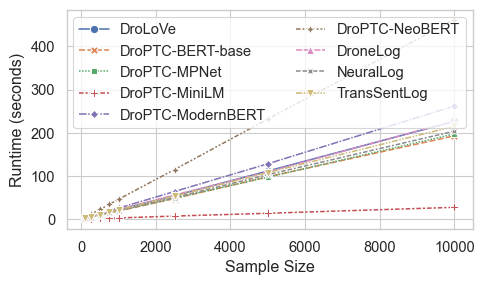

In [64]:
generate_visz(df[df['device'] == 'cpu'], 'cpu', 2)

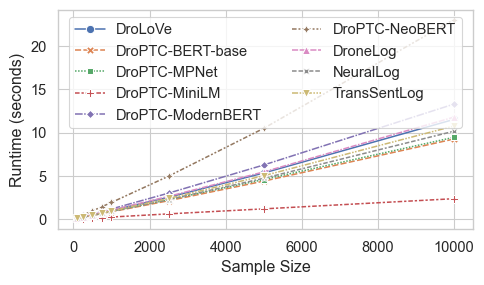

In [65]:
generate_visz(df[df['device'] == 'cuda'], 'cuda', 2)

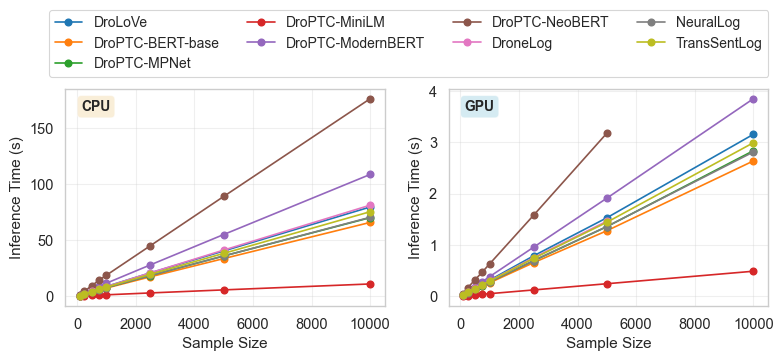

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is named 'df'
# df = pd.DataFrame with columns: scenario, device, sample_size, inference_time_s

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Get unique scenarios for consistent colors
scenarios = df['scenario'].unique()
colors = plt.cm.tab10(range(len(scenarios)))

# Plot for CPU (left subplot)
cpu_data = df[df['device'] == 'cpu']
for i, scenario in enumerate(scenarios):
    scenario_data = cpu_data[cpu_data['scenario'] == scenario]
    axes[0].plot(scenario_data['sample_size'], 
                 scenario_data['inference_time_s'],
                 marker='o', 
                 label=scenario,
                 color=colors[i])

axes.set_xlabel('Sample Size', fontsize=11)
axes.set_ylabel('Inference Time (s)', fontsize=11)
# axes.set_title('CPU', fontsize=12, fontweight='bold')
axes.grid(True, alpha=0.3)
axes.text(0.05, 0.95, 'CPU', transform=axes[0].transAxes,
             fontsize=10, fontweight='bold', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for GPU (right subplot)
gpu_data = df[df['device'] == 'cuda']
for i, scenario in enumerate(scenarios):
    scenario_data = gpu_data[gpu_data['scenario'] == scenario]
    axes[1].plot(scenario_data['sample_size'], 
                 scenario_data['inference_time_s'],
                 marker='o', 
                 label=scenario,
                 color=colors[i])

axes[1].set_xlabel('Sample Size', fontsize=11)
axes[1].set_ylabel('Inference Time (s)', fontsize=11)
# axes[1].set_title('GPU', fontsize=9, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, 'GPU', transform=axes[1].transAxes,
             fontsize=10, fontweight='bold', va='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Create a single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 1.218),
           ncol=4, frameon=True, fontsize=10)

# Adjust layout to prevent overlap
# plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.tight_layout()
plt.savefig(f'../visualization/efficiency-test/runtime-merged-3.pdf', bbox_inches='tight', dpi=600)
plt.show()

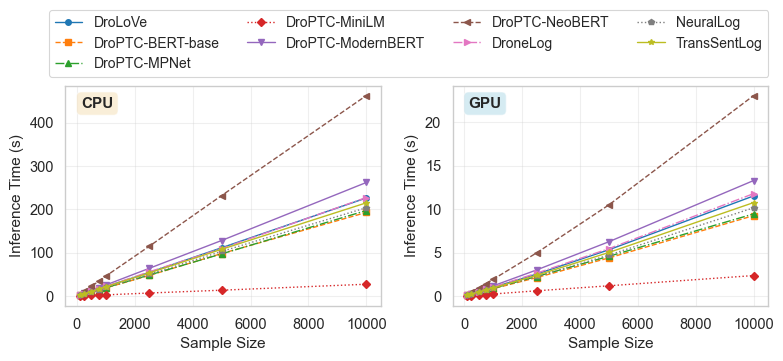

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is named 'df'
# df = pd.DataFrame with columns: scenario, device, sample_size, inference_time_s

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Get unique scenarios for consistent colors, markers, and line styles
scenarios = df['scenario'].unique()
colors = plt.cm.tab10(range(len(scenarios)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

# Plot for CPU (left subplot)
cpu_data = df[df['device'] == 'cpu']
for i, scenario in enumerate(scenarios):
    scenario_data = cpu_data[cpu_data['scenario'] == scenario]
    axes[0].plot(scenario_data['sample_size'], 
                 scenario_data['inference_time_s'],
                 marker=markers[i % len(markers)], 
                 linestyle=linestyles[i % len(linestyles)],
                 label=scenario,
                 color=colors[i],
                 linewidth=1,
                 markersize=4)

axes[0].set_xlabel('Sample Size', fontsize=11)
axes[0].set_ylabel('Inference Time (s)', fontsize=11)
# axes[0].set_title('CPU', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, 'CPU', transform=axes[0].transAxes,
             fontsize=11, fontweight='bold', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot for GPU (right subplot)
gpu_data = df[df['device'] == 'cuda']
for i, scenario in enumerate(scenarios):
    scenario_data = gpu_data[gpu_data['scenario'] == scenario]
    axes[1].plot(scenario_data['sample_size'], 
                 scenario_data['inference_time_s'],
                 marker=markers[i % len(markers)], 
                 linestyle=linestyles[i % len(linestyles)],
                 label=scenario,
                 color=colors[i],
                 linewidth=1,
                 markersize=4)

axes[1].set_xlabel('Sample Size', fontsize=11)
axes[1].set_ylabel('Inference Time (s)', fontsize=11)
# axes[1].set_title('GPU', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, 'GPU', transform=axes[1].transAxes,
             fontsize=11, fontweight='bold', va='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Create a single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 1.218),
           ncol=4, frameon=True, fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'../visualization/efficiency-test/runtime-merged-2.pdf', bbox_inches='tight', dpi=600)
plt.show()

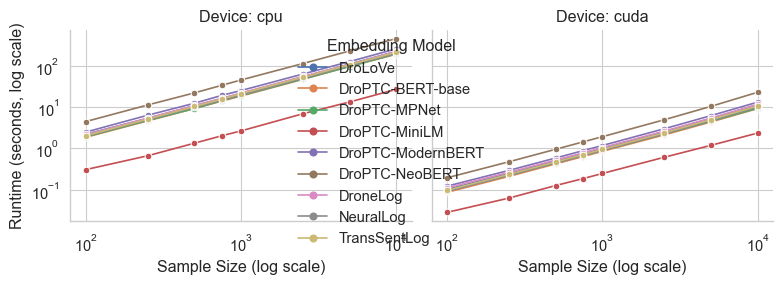

In [68]:
# Create a faceted plot using seaborn
g = sns.relplot(
    data=df,
    x='sample_size',
    y='inference_time_s',
    hue='scenario',
    col='device',
    kind='line',
    marker='o',
    aspect=1,
    height=3
)

# Set log scale for both axes
g.set(xscale="log", yscale="log")

# Set titles and labels
# g.fig.suptitle('Inference Time vs. Sample Size by Device', y=1.03)
g.set_axis_labels('Sample Size (log scale)', 'Runtime (seconds, log scale)')
g.set_titles("Device: {col_name}")
g.legend.set_title("Embedding Model")
g.legend.set_loc('center')
# Adjust layout and save the figure
plt.tight_layout()
# plt.legend(loc='')
plt.savefig(f'../visualization/efficiency-test/runtime-merged.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
def generate_visz(dataframe, scenario, ncol):
    df = dataframe.copy()
    df['sample_size'] = pd.to_numeric(df['sample_size'])
    df['avg_gpu_percent'] = pd.to_numeric(df['avg_gpu_percent'])

    # Convert sample_size to thousands for labeling
    df['sample_size_k'] = df['sample_size']

    plt.figure(figsize=(4, 3))
    sns.set_style("whitegrid")
    # sns.set_palette("husl")

    # Create line plot
    ax = sns.lineplot(data=df, x='sample_size_k', y='avg_gpu_percent', hue='model', 
                    style='model', markers=True, dashes=True, markersize=6, linewidth=1.1)

    # Set logarithmic scale if data spans several orders of magnitude
    if df['sample_size_k'].max() / df['sample_size_k'].min() > 100:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(1, 100000)
        ax.set_xlabel('Sample Size (log scale)')
        ax.set_ylabel('Runtime (seconds, log scale)')
    else:
        ax.set_xlabel('Sample Size (thousands)')
        ax.set_ylabel('Runtime (seconds)')

    # plt.title('Log Abstraction Efficiency Comparison', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.), ncol=ncol)
    plt.tight_layout()
    plt.savefig(f'../visualization/efficiency-test/{scenario}.pdf', bbox_inches='tight', dpi=600)
    plt.show()

## 4. Conclusion

The plots above provide a comprehensive overview of the performance trade-offs between the `all-MiniLM-L6-v2` and `all-mpnet-base-v2` models. By examining the inference time and resource utilization, we can make an informed decision about which model best suits our needs, balancing performance with computational cost. The smaller `all-MiniLM-L6-v2` model is expected to show significantly lower inference times and resource usage, justifying its use in resource-constrained environments despite a potential small drop in F1-score.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import json

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

class EfficiencyAnalyzer:
    """
    Analyze and compare efficiency of different models for digital forensics.
    """
    
    def __init__(self):
        self.results = {}
        
    def load_efficiency_results(self, results_file):
        """
        Load efficiency test results.
        
        Expected format (CSV or dict):
        {
            'model_name': {
                'cpu': {100: runtime, 500: runtime, ...},
                'gpu': {100: runtime, 500: runtime, ...},
                'params': number_of_parameters,
                'embedding_dim': dimension
            }
        }
        """
        if isinstance(results_file, str):
            # Load from file
            if results_file.endswith('.json'):
                with open(results_file, 'r') as f:
                    self.results = json.load(f)
            elif results_file.endswith('.csv'):
                df = pd.read_csv(results_file)
                # Convert to nested dict format
                self.results = self._csv_to_dict(df)
        else:
            # Assume it's already a dict
            self.results = results_file
        
        return self
    
    def _csv_to_dict(self, df):
        """Convert CSV format to nested dict."""
        results = {}
        
        for _, row in df.iterrows():
            model_name = row['model']
            device = row['device']
            sample_size = int(row['sample_size'])
            runtime = float(row['runtime'])
            
            if model_name not in results:
                results[model_name] = {
                    'cpu': {},
                    'gpu': {},
                    'params': row.get('params', 0),
                    'embedding_dim': row.get('embedding_dim', 0)
                }
            
            results[model_name][device][sample_size] = runtime
        
        return results
    
    def compute_throughput(self):
        """Compute throughput (samples/second) for each configuration."""
        for model_name, model_data in self.results.items():
            for device in ['cpu', 'gpu']:
                if device in model_data and model_data[device]:
                    throughput = {}
                    for sample_size, runtime in model_data[device].items():
                        throughput[int(sample_size)] = int(sample_size) / runtime
                    model_data[f'{device}_throughput'] = throughput
        
        return self
    
    def compute_efficiency_score(self):
        """
        Compute efficiency score combining speed and model size.
        Score = Throughput / (Parameters / 1M)
        Higher is better.
        """
        for model_name, model_data in self.results.items():
            params = model_data.get('params', 1e6)
            params_millions = params / 1e6
            
            for device in ['cpu', 'gpu']:
                throughput_key = f'{device}_throughput'
                if throughput_key in model_data:
                    # Use average throughput across sample sizes
                    avg_throughput = np.mean(list(model_data[throughput_key].values()))
                    model_data[f'{device}_efficiency_score'] = avg_throughput / params_millions
        
        return self
    
    def plot_runtime_comparison(self, device='both', figsize=(14, 10), 
                               save_path=None, sample_sizes=None):
        """
        Plot runtime comparison across models and sample sizes.
        
        Parameters:
        device: 'cpu', 'gpu', or 'both'
        sample_sizes: List of sample sizes to plot (None for all)
        """
        devices_to_plot = ['cpu', 'gpu'] if device == 'both' else [device]
        n_devices = len(devices_to_plot)
        
        fig, axes = plt.subplots(n_devices, 2, figsize=figsize)
        if n_devices == 1:
            axes = axes.reshape(1, -1)
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.results)))
        
        for dev_idx, dev in enumerate(devices_to_plot):
            # 1. Runtime vs Sample Size (Line Plot)
            ax1 = axes[dev_idx, 0]
            
            for i, (model_name, model_data) in enumerate(self.results.items()):
                if dev not in model_data or not model_data[dev]:
                    continue
                
                sizes = sorted(model_data[dev].keys())
                runtimes = [model_data[dev][s] for s in sizes]
                
                # Filter by sample_sizes if specified
                if sample_sizes:
                    filtered = [(s, r) for s, r in zip(sizes, runtimes) if s in sample_sizes]
                    if filtered:
                        sizes, runtimes = zip(*filtered)
                
                ax1.plot(sizes, runtimes, 'o-', label=model_name, 
                        color=colors[i], linewidth=2, markersize=8)
            
            ax1.set_xlabel('Sample Size (number of logs)', fontweight='bold', fontsize=12)
            ax1.set_ylabel('Runtime (seconds)', fontweight='bold', fontsize=12)
            ax1.set_title(f'Runtime vs Sample Size ({dev.upper()})', 
                         fontweight='bold', fontsize=14)
            ax1.legend(loc='best', fontsize=10)
            ax1.grid(True, alpha=0.3)
            ax1.set_xscale('log')
            ax1.set_yscale('log')
            
            # 2. Throughput Comparison (Bar Plot)
            ax2 = axes[dev_idx, 1]
            
            throughput_data = []
            model_names = []
            
            for model_name, model_data in self.results.items():
                throughput_key = f'{dev}_throughput'
                if throughput_key in model_data:
                    # Average throughput across all sample sizes
                    avg_throughput = np.mean(list(model_data[throughput_key].values()))
                    throughput_data.append(avg_throughput)
                    model_names.append(model_name)
            
            if throughput_data:
                bars = ax2.barh(range(len(throughput_data)), throughput_data, 
                               color=colors[:len(throughput_data)], alpha=0.7)
                ax2.set_yticks(range(len(model_names)))
                ax2.set_yticklabels(model_names, fontsize=10)
                ax2.set_xlabel('Average Throughput (samples/second)', 
                              fontweight='bold', fontsize=12)
                ax2.set_title(f'Average Throughput ({dev.upper()})', 
                             fontweight='bold', fontsize=14)
                ax2.grid(True, alpha=0.3, axis='x')
                
                # Add value labels
                for i, (bar, val) in enumerate(zip(bars, throughput_data)):
                    ax2.text(val, bar.get_y() + bar.get_height()/2, 
                            f'{val:.1f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_operational_range_detail(self, sample_sizes=[100, 250, 500, 750, 1000],
                                      device='cpu', figsize=(12, 5), save_path=None):
        """
        Detailed analysis of operational range (realistic sample sizes).
        """
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        fig.suptitle(f'Operational Range Analysis ({device.upper()}): {min(sample_sizes)}-{max(sample_sizes)} logs',
                    fontsize=14, fontweight='bold')
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.results)))
        
        # 1. Runtime comparison for operational range
        ax1 = axes[0]
        
        for i, (model_name, model_data) in enumerate(self.results.items()):
            if device not in model_data:
                continue
            
            runtimes = []
            valid_sizes = []
            
            for size in sample_sizes:
                if size in model_data[device]:
                    runtimes.append(model_data[device][size])
                    valid_sizes.append(size)
            
            if runtimes:
                ax1.plot(valid_sizes, runtimes, 'o-', label=model_name,
                        color=colors[i], linewidth=2, markersize=10)
        
        ax1.set_xlabel('Sample Size', fontweight='bold')
        ax1.set_ylabel('Runtime (seconds)', fontweight='bold')
        ax1.set_title('Runtime in Operational Range', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Relative speedup (compared to slowest)
        ax2 = axes[1]
        
        # Get runtimes at largest operational size
        max_size = max(sample_sizes)
        runtimes_at_max = {}
        
        for model_name, model_data in self.results.items():
            if device in model_data and max_size in model_data[device]:
                runtimes_at_max[model_name] = model_data[device][max_size]
        
        if runtimes_at_max:
            slowest_runtime = max(runtimes_at_max.values())
            speedups = {name: slowest_runtime / runtime 
                       for name, runtime in runtimes_at_max.items()}
            
            models = list(speedups.keys())
            speedup_values = list(speedups.values())
            
            bars = ax2.barh(range(len(models)), speedup_values, 
                           color=colors[:len(models)], alpha=0.7)
            ax2.set_yticks(range(len(models)))
            ax2.set_yticklabels(models)
            ax2.set_xlabel('Speedup Factor', fontweight='bold')
            ax2.set_title(f'Relative Speedup at {max_size} logs', fontweight='bold')
            ax2.axvline(x=1, color='red', linestyle='--', linewidth=1, label='Baseline')
            ax2.grid(True, alpha=0.3, axis='x')
            ax2.legend()
            
            # Add value labels
            for bar, val in zip(bars, speedup_values):
                ax2.text(val, bar.get_y() + bar.get_height()/2,
                        f'{val:.2f}x', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_efficiency_vs_accuracy(self, accuracy_dict, device='cpu', 
                                    figsize=(10, 8), save_path=None):
        """
        Plot efficiency-accuracy trade-off.
        
        Parameters:
        accuracy_dict: Dict mapping model_name to accuracy/F1 score
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        colors = plt.cm.tab10(np.linspace(0, 1, len(self.results)))
        
        throughputs = []
        accuracies = []
        model_names = []
        param_sizes = []
        
        for model_name, model_data in self.results.items():
            throughput_key = f'{device}_throughput'
            if throughput_key in model_data and model_name in accuracy_dict:
                avg_throughput = np.mean(list(model_data[throughput_key].values()))
                throughputs.append(avg_throughput)
                accuracies.append(accuracy_dict[model_name])
                model_names.append(model_name)
                params = model_data.get('params', 0) / 1e6  # in millions
                param_sizes.append(params)
        
        # Scatter plot with size representing parameter count
        scatter = ax.scatter(throughputs, accuracies, 
                           s=[p*100 for p in param_sizes],  # Scale for visibility
                           c=colors[:len(model_names)], 
                           alpha=0.6, edgecolors='black', linewidth=2)
        
        # Add labels
        for i, name in enumerate(model_names):
            ax.annotate(name, (throughputs[i], accuracies[i]), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Average Throughput (samples/second)', fontweight='bold', fontsize=12)
        ax.set_ylabel('Accuracy / F1 Score', fontweight='bold', fontsize=12)
        ax.set_title(f'Efficiency vs Accuracy Trade-off ({device.upper()})\n(Bubble size = model parameters)',
                    fontweight='bold', fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Add quadrant lines (median values)
        if throughputs and accuracies:
            median_throughput = np.median(throughputs)
            median_accuracy = np.median(accuracies)
            ax.axvline(x=median_throughput, color='gray', linestyle='--', alpha=0.5)
            ax.axhline(y=median_accuracy, color='gray', linestyle='--', alpha=0.5)
            
            # Add quadrant labels
            ax.text(0.95, 0.95, 'High Accuracy\nHigh Speed', 
                   transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                   fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def generate_efficiency_table(self, sample_sizes=[100, 500, 1000], device='cpu'):
        """
        Generate detailed efficiency comparison table.
        """
        print("=" * 120)
        print(f"EFFICIENCY COMPARISON TABLE ({device.upper()})")
        print("=" * 120)
        
        table_data = []
        
        for model_name, model_data in self.results.items():
            if device not in model_data:
                continue
            
            row = {
                'Model': model_name,
                'Parameters (M)': f"{model_data.get('params', 0) / 1e6:.2f}",
                'Embedding Dim': model_data.get('embedding_dim', 'N/A')
            }
            
            # Add runtime for each sample size
            for size in sample_sizes:
                if size in model_data[device]:
                    runtime = model_data[device][size]
                    row[f'Runtime@{size}'] = f"{runtime:.3f}s"
                else:
                    row[f'Runtime@{size}'] = 'N/A'
            
            # Add average throughput
            throughput_key = f'{device}_throughput'
            if throughput_key in model_data:
                avg_throughput = np.mean(list(model_data[throughput_key].values()))
                row['Avg Throughput'] = f"{avg_throughput:.1f} samples/s"
            
            # Add efficiency score
            eff_key = f'{device}_efficiency_score'
            if eff_key in model_data:
                row['Efficiency Score'] = f"{model_data[eff_key]:.2f}"
            
            table_data.append(row)
        
        df = pd.DataFrame(table_data)
        print(df.to_string(index=False))
        print("\n")
        
        return df
    
    def summary(self):
        """Print comprehensive summary."""
        print("=" * 120)
        print("EFFICIENCY ANALYSIS SUMMARY")
        print("=" * 120)
        
        for device in ['cpu', 'gpu']:
            print(f"\n{device.upper()} Performance:")
            print("-" * 120)
            
            fastest_model = None
            fastest_throughput = 0
            
            for model_name, model_data in self.results.items():
                throughput_key = f'{device}_throughput'
                if throughput_key in model_data:
                    avg_throughput = np.mean(list(model_data[throughput_key].values()))
                    if avg_throughput > fastest_throughput:
                        fastest_throughput = avg_throughput
                        fastest_model = model_name
                    
                    params = model_data.get('params', 0) / 1e6
                    print(f"  {model_name:30s} - Avg Throughput: {avg_throughput:8.1f} samples/s, "
                          f"Parameters: {params:6.2f}M")
            
            if fastest_model:
                print(f"\n  ⭐ Fastest Model: {fastest_model} ({fastest_throughput:.1f} samples/s)")


In [6]:

# Example usage
def main(results, accuracy_dict):
    # Example: Create sample efficiency results
    # results = {
    #     'DroPTC-BERT-base': {
    #         'cpu': {100: 0.5, 500: 2.1, 1000: 4.0, 5000: 19.5, 10000: 38.2},
    #         'gpu': {100: 0.1, 500: 0.4, 1000: 0.8, 5000: 3.8, 10000: 7.5},
    #         'params': 110e6,
    #         'embedding_dim': 768
    #     },
    #     'DroPTC-DistilBERT': {
    #         'cpu': {100: 0.3, 500: 1.3, 1000: 2.5, 5000: 12.0, 10000: 23.5},
    #         'gpu': {100: 0.08, 500: 0.3, 1000: 0.6, 5000: 2.8, 10000: 5.5},
    #         'params': 66e6,
    #         'embedding_dim': 768
    #     },
    #     'Baseline-BiLSTM': {
    #         'cpu': {100: 0.8, 500: 3.5, 1000: 6.8, 5000: 33.2, 10000: 65.5},
    #         'gpu': {100: 0.15, 500: 0.7, 1000: 1.3, 5000: 6.5, 10000: 12.8},
    #         'params': 25e6,
    #         'embedding_dim': 300
    #     }
    # }
    
    # # Accuracy data (example)
    # accuracy_dict = {
    #     'DroPTC-BERT-base': 0.95,
    #     'DroPTC-DistilBERT': 0.93,
    #     'Baseline-BiLSTM': 0.87
    # }
    
    # Initialize analyzer
    analyzer = EfficiencyAnalyzer()
    analyzer.results = results
    analyzer.compute_throughput()
    analyzer.compute_efficiency_score()
    
    # Generate visualizations
    print("Generating efficiency analysis...\n")
    
    analyzer.plot_runtime_comparison(device='both', save_path='runtime_comparison.png')
    
    analyzer.plot_operational_range_detail(
        sample_sizes=[100, 250, 500, 750, 1000],
        device='cpu',
        save_path='operational_range.png'
    )
    
    analyzer.plot_efficiency_vs_accuracy(
        accuracy_dict,
        device='cpu',
        save_path='efficiency_accuracy_tradeoff.png'
    )
    
    # Generate tables
    cpu_table = analyzer.generate_efficiency_table(
        sample_sizes=['100', '500', '1000'],
        device='cpu'
    )
    
    analyzer.summary()
    
    print("\n✓ Efficiency analysis complete!")

In [7]:
import os
import json

recap_file = os.path.join('..', 'experiments', 'efficiency_test', 'results_formatted.json')
with open(recap_file, 'r') as f:
    recap_data = json.load(f)
    for key in recap_data:
        print(key)
accuracy_dict = {
    'DroLoVe': 0.915,
    'DroneLog': 0.909,
    'DroPTC-MiniLM': 0.924,
    'DroPTC-MPNet': 0.928,
    'DroPTC-BERT-base': 0.917,
    'DroPTC-ModernBERT': 0.906,
    'DroPTC-NeoBERT': 0.911,
    'NeuralLog': 0.918,
    'TransSentLog': 0.918
}

main(recap_data, accuracy_dict) 

FileNotFoundError: [Errno 2] No such file or directory: '..\\experiments\\efficiency_test\\results_formatted.json'

In [8]:
df['scenario'].unique()

array(['DroLoVe', 'DroPTC-BERT-base', 'DroPTC-MPNet', 'DroPTC-MiniLM',
       'DroPTC-ModernBERT', 'DroPTC-NeoBERT', 'DroneLog', 'NeuralLog',
       'TransSentLog'], dtype=object)

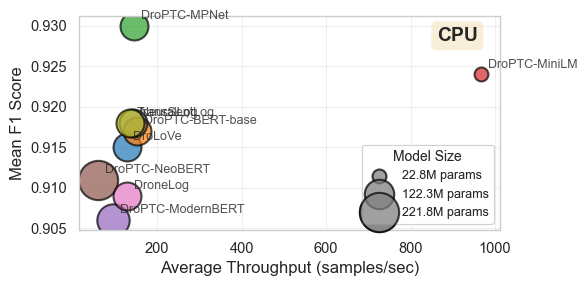

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your dataframe is named 'df' with columns:
# scenario, device, sample_size, inference_time_s, f1_score, model_params

# Hard-coded F1 scores and model parameters
accuracy_dict = {
    'DroLoVe': 0.915,
    'DroPTC-BERT-base': 0.917,
    'DroPTC-MPNet': 0.930,
    'DroPTC-MiniLM': 0.924,
    'DroPTC-ModernBERT': 0.906,
    'DroPTC-NeoBERT': 0.911,
    'DroneLog': 0.909,
    'NeuralLog': 0.918,
    'TransSentLog': 0.918
}
model_metadata = {
    'DroLoVe': 109581575,
    'DroPTC-BERT-base': 109581575,
    'DroPTC-MPNet': 109585799,
    'DroPTC-MiniLM': 22763399,
    'DroPTC-ModernBERT': 149113607,
    'DroPTC-NeoBERT': 221764871,
    'DroneLog': 109585799,
    'NeuralLog': 109581575,
    'TransSentLog': 109581575
}

# Calculate throughput (samples/sec)
df['throughput'] = df['sample_size'] / df['inference_time_s']

# Calculate average throughput per scenario and device
plot_data = df.groupby(['scenario', 'device'])['throughput'].mean().reset_index()
plot_data.columns = ['scenario', 'device', 'avg_throughput']

# Add F1 score and model parameters
plot_data['f1_score'] = plot_data['scenario'].map(accuracy_dict)
plot_data['model_params'] = plot_data['scenario'].map(model_metadata)

# Create figure with two subplots (CPU and GPU)
fig, axes = plt.subplots(1, 1, figsize=(6, 3), sharey=True)

# Get unique scenarios for consistent colors
scenarios = plot_data['scenario'].unique()
colors = plt.cm.tab10(range(len(scenarios)))
color_map = {scenario: colors[i] for i, scenario in enumerate(scenarios)}

# Normalize parameter sizes for marker sizing (scale between 50 and 500)
min_params = plot_data['model_params'].min()
max_params = plot_data['model_params'].max()
size_range = (100, 800)
plot_data['marker_size'] = size_range[0] + (plot_data['model_params'] - min_params) / (max_params - min_params) * (size_range[1] - size_range[0])

# Plot for CPU
cpu_data = plot_data[plot_data['device'] == 'cpu']
for scenario in scenarios:
    scenario_data = cpu_data[cpu_data['scenario'] == scenario]
    if not scenario_data.empty:
        axes.scatter(scenario_data['avg_throughput'], 
                       scenario_data['f1_score'],
                       s=scenario_data['marker_size'],
                       color=color_map[scenario],
                       alpha=0.7,
                       edgecolors='black',
                       linewidth=1.5,
                       label=scenario)
        
        # Add scenario labels
        for _, row in scenario_data.iterrows():
            axes.annotate(scenario, 
                           (row['avg_throughput'], row['f1_score']),
                           xytext=(5, 5), 
                           textcoords='offset points',
                           fontsize=9,
                           alpha=0.8)

axes.set_xlabel('Average Throughput (samples/sec)', fontsize=12)
axes.set_ylabel('Mean F1 Score', fontsize=12)
# axes.set_title('CPU Performance', fontsize=13, fontweight='bold')
axes.grid(True, alpha=0.3)
axes.text(0.85, 0.95, 'CPU', transform=axes.transAxes,
            fontsize=14, fontweight='bold', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# # Plot for GPU
# gpu_data = plot_data[plot_data['device'] == 'cuda']
# for scenario in scenarios:
#     scenario_data = gpu_data[gpu_data['scenario'] == scenario]
#     if not scenario_data.empty:
#         axes[1].scatter(scenario_data['avg_throughput'], 
#                        scenario_data['f1_score'],
#                        s=scenario_data['marker_size'],
#                        color=color_map[scenario],
#                        alpha=0.7,
#                        edgecolors='black',
#                        linewidth=1.5,
#                        label=scenario)
        
#         # Add scenario labels
#         for _, row in scenario_data.iterrows():
#             axes[1].annotate(scenario, 
#                            (row['avg_throughput'], row['f1_score']),
#                            xytext=(5, 5), 
#                            textcoords='offset points',
#                            fontsize=9,
#                            alpha=0.8)

# axes[1].set_xlabel('Average Throughput (samples/sec)', fontsize=12)
# # axes[1].set_ylabel('F1 Score', fontsize=12)
# # axes[1].set_title('GPU Performance', fontsize=13, fontweight='bold')
# axes[1].grid(True, alpha=0.3)
# axes[1].text(0.85, 0.95, 'GPU', transform=axes[1].transAxes,
#             fontsize=14, fontweight='bold', va='top',
#             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Create a legend for scenarios
handles, labels = axes.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(scenarios), frameon=False)

# Add a size legend for parameter count
size_legend_elements = []
param_values = [min_params, (min_params + max_params) / 2, max_params]
for param_val in param_values:
    size = size_range[0] + (param_val - min_params) / (max_params - min_params) * (size_range[1] - size_range[0])
    size_legend_elements.append(plt.scatter([], [], s=size, c='gray', alpha=0.7, 
                                           edgecolors='black', linewidth=1.5,
                                           label=f'{param_val/1e6:.1f}M params'))

size_legend = axes.legend(handles=size_legend_elements, 
                            loc='lower right', 
                            frameon=True, 
                            fontsize=9,
                            title='Model Size',
                            title_fontsize=10)
axes.add_artist(size_legend)

plt.tight_layout()
# plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.savefig(f'../visualization/efficiency-test/trade-off-cpu.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [1]:
import json
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class EfficiencyVisualizer:
    """Modular visualizer for drone log analysis efficiency tests."""
    
    def __init__(self, base_path="experiments/efficiency_test"):
        self.base_path = Path(base_path)
        self.data = None
    
    def load_data(self, device='cpu'):
        """
        Load all efficiency test results for specified device.
        
        Args:
            device: 'cpu' or 'cuda'
        
        Returns:
            Dictionary with structure: {scenario: {embedding: [results]}}
        """
        data = defaultdict(lambda: defaultdict(list))
        
        # Traverse directory structure
        for scenario_dir in self.base_path.iterdir():
            if not scenario_dir.is_dir():
                continue
            
            scenario = scenario_dir.name
            
            for embedding_dir in scenario_dir.iterdir():
                if not embedding_dir.is_dir():
                    continue
                
                embedding = embedding_dir.name
                
                device_dir = embedding_dir / device
                if not device_dir.exists():
                    continue
                
                # Load all sample size results
                for sample_dir in device_dir.iterdir():
                    if not sample_dir.is_dir():
                        continue
                    
                    result_file = sample_dir / "result.json"
                    if result_file.exists():
                        with open(result_file, 'r') as f:
                            result = json.load(f)
                            # Calculate throughput (samples/second)
                            result['throughput'] = result['sample_size'] / result['inference_time_s']
                            data[scenario][embedding].append(result)
        
        self.data = data
        return data
    
    def calculate_stats(self, results):
        """
        Calculate mean and std of throughput across sample sizes.
        
        Args:
            results: List of result dictionaries
        
        Returns:
            Dictionary with mean, std, and other stats
        """
        throughputs = [r['throughput'] for r in results]
        
        stats = {
            'mean_throughput': np.mean(throughputs),
            'std_throughput': np.std(throughputs),
            'num_samples': len(throughputs),
            # Placeholder for memory consumption
            # 'mean_memory_mb': np.mean([r['peak_memory_mb'] for r in results]),
            # 'std_memory_mb': np.std([r['peak_memory_mb'] for r in results]),
        }
        
        return stats
    
    def prepare_plot1_data(self, best_model_embedding='all-MiniLM-L6-v2'):
        """
        Prepare data for Plot 1: Best model vs baselines.
        
        Args:
            best_model_embedding: Embedding to use for the proposed model (droptc)
        
        Returns:
            Dictionary with model names and their stats
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        plot_data = {}
        
        # Process all scenarios
        for scenario, embeddings in self.data.items():
            if scenario == 'droptc':
                # Use specified embedding for best model
                if best_model_embedding in embeddings:
                    results = embeddings[best_model_embedding]
                    plot_data[f'DropTC ({best_model_embedding})'] = self.calculate_stats(results)
            else:
                # For baselines, use all available embeddings
                for embedding, results in embeddings.items():
                    model_name = f'{scenario} ({embedding})'
                    plot_data[model_name] = self.calculate_stats(results)
        
        return plot_data
    
    def prepare_plot2_data(self):
        """
        Prepare data for Plot 2: DropTC with different embeddings.
        
        Returns:
            Dictionary with embedding names and their stats
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        plot_data = {}
        
        if 'droptc' not in self.data:
            raise ValueError("DropTC scenario not found in data.")
        
        for embedding, results in self.data['droptc'].items():
            plot_data[embedding] = self.calculate_stats(results)
        
        return plot_data
    
    def plot_comparison(self, plot_data, title, filename, color_best=None):
        """
        Create bar plot with dual y-axes (throughput + memory placeholder).
        
        Args:
            plot_data: Dictionary with model names and stats
            title: Plot title
            filename: Output filename
            color_best: If provided, highlight this model name in different color
        """
        models = list(plot_data.keys())
        mean_throughput = [plot_data[m]['mean_throughput'] for m in models]
        std_throughput = [plot_data[m]['std_throughput'] for m in models]
        
        # Placeholder for memory data
        # mean_memory = [plot_data[m]['mean_memory_mb'] for m in models]
        # std_memory = [plot_data[m]['std_memory_mb'] for m in models]
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Color setup
        colors = []
        for model in models:
            if color_best and color_best.lower() in model.lower():
                colors.append('#2ecc71')  # Green for best model
            else:
                colors.append('#3498db')  # Blue for others
        
        # Plot throughput (left y-axis)
        x_pos = np.arange(len(models))
        bars1 = ax1.bar(x_pos, mean_throughput, yerr=std_throughput, 
                        capsize=5, alpha=0.8, color=colors, 
                        edgecolor='black', linewidth=1.2)
        
        ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Throughput (samples/sec)', fontsize=12, fontweight='bold', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Placeholder for memory consumption (right y-axis)
        # ax2 = ax1.twinx()
        # ax2.plot(x_pos, mean_memory, 'ro-', linewidth=2, markersize=8, 
        #          label='Peak Memory', alpha=0.7)
        # ax2.fill_between(x_pos, 
        #                   np.array(mean_memory) - np.array(std_memory),
        #                   np.array(mean_memory) + np.array(std_memory),
        #                   alpha=0.2, color='red')
        # ax2.set_ylabel('Peak Memory (MB)', fontsize=12, fontweight='bold', color='red')
        # ax2.tick_params(axis='y', labelcolor='red')
        
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        
        # Add legend
        # ax1.legend(['Throughput'], loc='upper left')
        # ax2.legend(['Peak Memory'], loc='upper right')
        
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")
        plt.close()
    
    def generate_plots(self, device='cpu', output_dir='plots'):
        """
        Generate both plots for the specified device.
        
        Args:
            device: 'cpu' or 'cuda'
            output_dir: Directory to save plots
        """
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Load data
        print(f"Loading {device.upper()} data...")
        self.load_data(device=device)
        
        # Plot 1: Best model vs baselines
        print("Generating Plot 1: Best model vs baselines...")
        plot1_data = self.prepare_plot1_data(best_model_embedding='all-MiniLM-L6-v2')
        self.plot_comparison(
            plot1_data,
            title=f'Efficiency Comparison: DropTC vs Baselines ({device.upper()})',
            filename=f'{output_dir}/plot1_comparison_{device}.png',
            color_best='droptc'
        )
        
        # Print statistics for Plot 1
        print("\n=== Plot 1 Statistics ===")
        for model, stats in plot1_data.items():
            print(f"{model}:")
            print(f"  Throughput: {stats['mean_throughput']:.2f} ± {stats['std_throughput']:.2f} samples/sec")
            print(f"  Based on {stats['num_samples']} sample sizes")
        
        # Plot 2: DropTC with different embeddings
        print("\nGenerating Plot 2: DropTC embedding comparison...")
        plot2_data = self.prepare_plot2_data()
        self.plot_comparison(
            plot2_data,
            title=f'DropTC Embedding Comparison ({device.upper()})',
            filename=f'{output_dir}/plot2_embeddings_{device}.png'
        )
        
        # Print statistics for Plot 2
        print("\n=== Plot 2 Statistics ===")
        for embedding, stats in plot2_data.items():
            print(f"{embedding}:")
            print(f"  Throughput: {stats['mean_throughput']:.2f} ± {stats['std_throughput']:.2f} samples/sec")
            print(f"  Based on {stats['num_samples']} sample sizes")
        
        print(f"\n✓ All plots generated successfully in '{output_dir}/' directory")

In [2]:

# Example usage
if __name__ == "__main__":
    visualizer = EfficiencyVisualizer(base_path="../experiments/efficiency_test")
    
    # Generate CPU plots (for main paper)
    visualizer.generate_plots(device='cpu', output_dir='../visualization/efficiency-test')
    
    # Generate CUDA plots (for appendix)
    # visualizer.generate_plots(device='cuda', output_dir='plots/cuda')

Loading CPU data...
Generating Plot 1: Best model vs baselines...
Plot saved to ../visualization/efficiency-test/plot1_comparison_cpu.png

=== Plot 1 Statistics ===
drolove (bert-base-uncased):
  Throughput: 45.65 ± 0.74 samples/sec
  Based on 8 sample sizes
dronelog (all-mpnet-base-v2):
  Throughput: 45.26 ± 0.60 samples/sec
  Based on 8 sample sizes
DropTC (all-MiniLM-L6-v2):
  Throughput: 363.99 ± 15.74 samples/sec
  Based on 8 sample sizes
neurallog (bert-base-uncased):
  Throughput: 49.80 ± 0.63 samples/sec
  Based on 8 sample sizes
transsentlog (bert-base-uncased):
  Throughput: 47.37 ± 0.83 samples/sec
  Based on 8 sample sizes

Generating Plot 2: DropTC embedding comparison...
Plot saved to ../visualization/efficiency-test/plot2_embeddings_cpu.png

=== Plot 2 Statistics ===
all-MiniLM-L6-v2:
  Throughput: 363.99 ± 15.74 samples/sec
  Based on 8 sample sizes
all-mpnet-base-v2:
  Throughput: 51.89 ± 0.77 samples/sec
  Based on 8 sample sizes
bert-base-uncased:
  Throughput: 52.86

In [1]:
import json
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class EfficiencyVisualizer:
    """Modular visualizer for drone log analysis efficiency tests."""
    
    # Scenario name mappings
    SCENARIO_NAMES = {
        'droptc': 'DroPTC',
        'drolove': 'DroLoVe',
        'dronelog': 'DroneLog',
        'neurallog': 'NeuralLog',
        'transsentlog': 'TransSentLog'
    }
    
    # Embedding name mappings
    EMBEDDING_NAMES = {
        'all-MiniLM-L6-v2': 'MiniLM',
        'all-mpnet-base-v2': 'MPNet',
        'bert-base-uncased': 'BERT-base',
        'neo-bert': 'NeoBERT',
        'modern-bert': 'ModernBERT'
    }
    
    def __init__(self, base_path="experiments/efficiency_test"):
        self.base_path = Path(base_path)
        self.data = None
    
    def format_scenario_name(self, scenario):
        """Format scenario name for display."""
        return self.SCENARIO_NAMES.get(scenario, scenario)
    
    def format_embedding_name(self, embedding):
        """Format embedding name for display."""
        # Keep all-* embeddings as-is, map others
        # if embedding.startswith('all-'):
        #     return embedding
        return self.EMBEDDING_NAMES.get(embedding, embedding)
    
    def load_data(self, device='cpu'):
        """
        Load all efficiency test results for specified device.
        
        Args:
            device: 'cpu' or 'cuda'
        
        Returns:
            Dictionary with structure: {scenario: {embedding: [results]}}
        """
        data = defaultdict(lambda: defaultdict(list))
        
        # Traverse directory structure
        for scenario_dir in self.base_path.iterdir():
            if not scenario_dir.is_dir():
                continue
            
            scenario = scenario_dir.name
            
            for embedding_dir in scenario_dir.iterdir():
                if not embedding_dir.is_dir():
                    continue
                
                embedding = embedding_dir.name
                
                device_dir = embedding_dir / device
                if not device_dir.exists():
                    continue
                
                # Load all sample size results
                for sample_dir in device_dir.iterdir():
                    if not sample_dir.is_dir():
                        continue
                    
                    result_file = sample_dir / "result.json"
                    if result_file.exists():
                        with open(result_file, 'r') as f:
                            result = json.load(f)
                            # Calculate throughput (samples/second)
                            result['throughput'] = result['sample_size'] / result['inference_time_s']
                            data[scenario][embedding].append(result)
        
        self.data = data
        return data
    
    def calculate_stats(self, results):
        """
        Calculate mean and std of throughput across sample sizes.
        
        Args:
            results: List of result dictionaries
        
        Returns:
            Dictionary with mean, std, and other stats
        """
        throughputs = [r['throughput'] for r in results]
        
        stats = {
            'mean_throughput': np.mean(throughputs),
            'std_throughput': np.std(throughputs),
            'num_samples': len(throughputs),
            # Placeholder for memory consumption
            # 'mean_memory_mb': np.mean([r['peak_memory_mb'] for r in results]),
            # 'std_memory_mb': np.std([r['peak_memory_mb'] for r in results]),
        }
        
        return stats
    
    def prepare_plot1_data(self, best_model_embedding='all-MiniLM-L6-v2'):
        """
        Prepare data for Plot 1: Best model vs baselines.
        
        Args:
            best_model_embedding: Embedding to use for the proposed model (droptc)
        
        Returns:
            Dictionary with model names and their stats
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        plot_data = {}
        
        # Process all scenarios
        for scenario, embeddings in self.data.items():
            if scenario == 'droptc':
                # Use specified embedding for best model
                if best_model_embedding in embeddings:
                    results = embeddings[best_model_embedding]
                    scenario_name = self.format_scenario_name(scenario)
                    embedding_name = self.format_embedding_name(best_model_embedding)
                    plot_data[f'{scenario_name}'] = self.calculate_stats(results)
            else:
                # For baselines, use all available embeddings
                for embedding, results in embeddings.items():
                    scenario_name = self.format_scenario_name(scenario)
                    embedding_name = self.format_embedding_name(embedding)
                    model_name = f'{scenario_name}'
                    plot_data[model_name] = self.calculate_stats(results)
        
        return plot_data
    
    def prepare_plot2_data(self):
        """
        Prepare data for Plot 2: DropTC with different embeddings.
        
        Returns:
            Dictionary with embedding names and their stats
        """
        if self.data is None:
            raise ValueError("Data not loaded. Call load_data() first.")
        
        plot_data = {}
        
        if 'droptc' not in self.data:
            raise ValueError("DropTC scenario not found in data.")
        
        for embedding, results in self.data['droptc'].items():
            embedding_name = self.format_embedding_name(embedding)
            plot_data[embedding_name] = self.calculate_stats(results)
        
        return plot_data
    
    def generate_plots(self, device='cpu', output_dir='plots'):
        """
        Generate both plots for the specified device in a single figure.
        
        Args:
            device: 'cpu' or 'cuda'
            output_dir: Directory to save plots
        """
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Load data
        print(f"Loading {device.upper()} data...")
        self.load_data(device=device)
        
        # Prepare data for both plots
        print("Preparing data...")
        plot1_data = self.prepare_plot1_data(best_model_embedding='all-MiniLM-L6-v2')
        plot2_data = self.prepare_plot2_data()
        
        # Create figure with two subplots side by side
        # Figure size optimized for one column in two-column paper (approx 7 inches total width)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
        
        # Technical style settings
        bar_color = '#757575'  # Grey color
        plt.rcParams['font.size'] = 8
        
        # Plot 1: Best model vs baselines
        models1 = list(plot1_data.keys())
        mean_throughput1 = [plot1_data[m]['mean_throughput'] for m in models1]
        std_throughput1 = [plot1_data[m]['std_throughput'] for m in models1]
        
        x_pos1 = np.arange(len(models1))
        bars1 = ax1.bar(x_pos1, mean_throughput1, color=bar_color, 
                        edgecolor='black', linewidth=0.8, width=0.7)
        
        # Add std annotations on top of bars
        for i, (bar, std) in enumerate(zip(bars1, std_throughput1)):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'±{std:.1f}',
                    ha='center', va='bottom', fontsize=7)
        
        ax1.set_xlabel('Model', fontsize=9)
        ax1.set_ylabel('Throughput', fontsize=9)
        ax1.set_xticks(x_pos1)
        ax1.set_xticklabels(models1, fontsize=7, ha='center', rotation=45)
        ax1.set_title('(a) DroPTC vs. Baselines', fontsize=9, pad=10)
        ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax1.tick_params(axis='both', labelsize=7)
        
        # Plot 2: DropTC with different embeddings
        models2 = list(plot2_data.keys())
        mean_throughput2 = [plot2_data[m]['mean_throughput'] for m in models2]
        std_throughput2 = [plot2_data[m]['std_throughput'] for m in models2]
        
        x_pos2 = np.arange(len(models2))
        bars2 = ax2.bar(x_pos2, mean_throughput2, color=bar_color,
                        edgecolor='black', linewidth=0.8, width=0.7)
        
        # Add std annotations on top of bars
        for i, (bar, std) in enumerate(zip(bars2, std_throughput2)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'±{std:.1f}',
                    ha='center', va='bottom', fontsize=7)
        
        ax2.set_xlabel('Embedding', fontsize=9)
        ax2.set_xticks(x_pos2)
        ax2.set_xticklabels(models2, fontsize=7, ha='center', rotation=45)
        ax2.set_title('(b) DroPTC Embeddings', fontsize=9, pad=10)
        ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax2.tick_params(axis='both', labelsize=7)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        # Save figure
        filename = f'{output_dir}/efficiency_comparison_{device}.pdf'
        plt.savefig(filename, dpi=300, bbox_inches='tight', format='pdf')
        print(f"Plot saved to {filename}")
        
        # Also save as PNG
        filename_png = f'{output_dir}/efficiency_comparison_{device}.png'
        plt.savefig(filename_png, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename_png}")
        
        plt.close()
        
        # Print statistics
        print("\n=== Plot 1 Statistics: DroPTC vs. Baselines ===")
        for model, stats in plot1_data.items():
            model_clean = model.replace('\n', ' ')
            print(f"{model_clean}:")
            print(f"  Throughput: {stats['mean_throughput']:.2f} ± {stats['std_throughput']:.2f} samples/sec")
            print(f"  Based on {stats['num_samples']} sample sizes")
        
        print("\n=== Plot 2 Statistics: DroPTC Embeddings ===")
        for embedding, stats in plot2_data.items():
            print(f"{embedding}:")
            print(f"  Throughput: {stats['mean_throughput']:.2f} ± {stats['std_throughput']:.2f} samples/sec")
            print(f"  Based on {stats['num_samples']} sample sizes")
        
        print(f"\n✓ Plots generated successfully in '{output_dir}/' directory")


In [2]:

# Example usage
# if __name__ == "__main__":
visualizer = EfficiencyVisualizer(base_path="../experiments/efficiency_test")

# Generate CPU plots (for main paper)
visualizer.generate_plots(device='cpu', output_dir='../visualization/efficiency-test')
    
    # Generate CUDA plots (for appendix)
    # visualizer.generate_plots(device='cuda', output_dir='plots/cuda')

Loading CPU data...
Preparing data...
Plot saved to ../visualization/efficiency-test/efficiency_comparison_cpu.pdf
Plot saved to ../visualization/efficiency-test/efficiency_comparison_cpu.png

=== Plot 1 Statistics: DroPTC vs. Baselines ===
DroLoVe:
  Throughput: 127.68 ± 22.25 samples/sec
  Based on 8 sample sizes
DroneLog:
  Throughput: 128.84 ± 25.66 samples/sec
  Based on 8 sample sizes
DroPTC:
  Throughput: 966.21 ± 193.70 samples/sec
  Based on 8 sample sizes
NeuralLog:
  Throughput: 143.82 ± 25.50 samples/sec
  Based on 8 sample sizes
TransSentLog:
  Throughput: 135.13 ± 22.73 samples/sec
  Based on 8 sample sizes

=== Plot 2 Statistics: DroPTC Embeddings ===
MiniLM:
  Throughput: 966.21 ± 193.70 samples/sec
  Based on 8 sample sizes
MPNet:
  Throughput: 144.87 ± 26.63 samples/sec
  Based on 8 sample sizes
BERT-base:
  Throughput: 153.52 ± 27.34 samples/sec
  Based on 8 sample sizes
ModernBERT:
  Throughput: 96.02 ± 17.21 samples/sec
  Based on 8 sample sizes
NeoBERT:
  Throughp

In [3]:
visualizer.generate_plots(device='cuda', output_dir='../visualization/efficiency-test')

Loading CUDA data...
Preparing data...
Plot saved to ../visualization/efficiency-test/efficiency_comparison_cuda.pdf
Plot saved to ../visualization/efficiency-test/efficiency_comparison_cuda.png

=== Plot 1 Statistics: DroPTC vs. Baselines ===
DroLoVe:
  Throughput: 3279.79 ± 316.95 samples/sec
  Based on 8 sample sizes
DroneLog:
  Throughput: 3414.01 ± 309.34 samples/sec
  Based on 7 sample sizes
DroPTC:
  Throughput: 18154.89 ± 1976.73 samples/sec
  Based on 8 sample sizes
NeuralLog:
  Throughput: 3672.98 ± 328.41 samples/sec
  Based on 8 sample sizes
TransSentLog:
  Throughput: 3456.29 ± 324.33 samples/sec
  Based on 8 sample sizes

=== Plot 2 Statistics: DroPTC Embeddings ===
MiniLM:
  Throughput: 18154.89 ± 1976.73 samples/sec
  Based on 8 sample sizes
MPNet:
  Throughput: 3723.09 ± 438.60 samples/sec
  Based on 8 sample sizes
BERT-base:
  Throughput: 3899.02 ± 326.46 samples/sec
  Based on 8 sample sizes
ModernBERT:
  Throughput: 2634.89 ± 108.55 samples/sec
  Based on 8 sample s